In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
# rcParams['figure.figsize'] = 5, 4
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# select device: change to 'cpu' if there's no GPU device
device = 'gpu'

if device == 'gpu':
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
class ScaleAndShift(nn.Module):
    def __init__(self, input_features, K=1):
        super(ScaleAndShift, self).__init__()
        self.input_features = input_features
        self.K = K

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        
        self.logscale = nn.Parameter(torch.Tensor(input_features,K))
        self.shift = nn.Parameter(torch.Tensor(input_features,K))

        self.logscale.data.uniform_(-1, 1)
        self.shift.data.uniform_(-1, 1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        
        batch_no = input.shape[0]
        p = self.input_features
        
        K = self.K
        
#         self.logscale = self.scale_raw  # torch.tanh(self.scale_raw)
        self.scale = torch.exp(self.logscale)
        
        x_rep = input.reshape([batch_no,1,p]).repeat(1,K,1)
        w_rep = self.scale.T.reshape([1,K,p]).repeat(batch_no,1,1)
        b_rep = self.shift.T.reshape([1,K,p]).repeat(batch_no,1,1)

        return x_rep*w_rep+b_rep

    def print_param(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'scale={}, shift={}'.format(
            self.scale, self.shift
        )

In [3]:
class KCat(nn.Module):
    def __init__(self, input_features, K=1):
        super(KCat, self).__init__()
        self.input_features = input_features
        self.K = K
        
        self.w = nn.Parameter(torch.Tensor(input_features,K))
        self.b0 = nn.Parameter(torch.Tensor(K))

        self.w.data.uniform_(-1, 1)
        self.b0.data.uniform_(-1, 1)

        
    def forward(self, input,dim=1):
        
        b = self.b0 - torch.logsumexp(self.b0,0,keepdim=True)
        
        xw_b = input@self.w+ b
        return xw_b - torch.logsumexp(xw_b,dim=dim,keepdim=True)

In [4]:
batch_no = 1000
p = 2
K = 100

In [5]:
scale_shift = ScaleAndShift(p,K)
kcat = KCat(p,K)

In [6]:
class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()
        
        s1 = 1
        
        sigma0 = 1
        Sigma1 = torch.tensor(np.reshape(np.array([1,0.5,0.5,1], np.float64),[2,2])) * sigma0**2
        Sigma2 = torch.tensor(np.reshape(np.array([1*s1**2,-0.9*s1,-0.9*s1,1], np.float64),[2,2])) * sigma0**2

        self.Omega1 = (Sigma1).inverse()
        self.Omega2 = (Sigma2).inverse()

        self.Mu1 = torch.tensor(np.matrix([5,2]))
        self.Mu2 = torch.tensor(np.matrix([-3,-1]))

        self.logSigma1 = torch.logdet(Sigma1)
        self.logSigma2 = torch.logdet(Sigma2)
              
    def f(self, theta):
        Mu1 = self.Mu1
        Mu2 = self.Mu2
        Omega1 = self.Omega1
        Omega2 = self.Omega2
        logSigma1 = self.logSigma1
        logSigma2 = self.logSigma2

        diff1 = (theta-Mu1)
        quad1 = torch.diagonal( diff1@Omega1@torch.transpose(diff1,1,2),dim1=1,dim2=2)

        diff2 = (theta-Mu2)
        quad2 = torch.diagonal( diff2@Omega2@torch.transpose(diff2,1,2),dim1=1,dim2=2)

        comp_loglik1 =  - quad1/2.0 - logSigma1/2.0 
        comp_loglik2 = - quad2/2.0 - logSigma2/2.0 

        loglik = torch.logsumexp(torch.stack([comp_loglik1,comp_loglik2]),dim=0) + np.log(0.5) -np.log(2*np.pi)
        return  loglik

compLoglik = Loglik()

In [7]:
para_list=list()
para_list +=  list(scale_shift.parameters())
para_list +=  list(kcat.parameters())

In [8]:
import copy

best_loss = np.inf

Optimize to learn the random transport, as a mixture of K maps

In [9]:

def dirichlet_prior(logb):
    alpha= 0.5
    return (alpha/K-1) * log_b.sum()

In [10]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-1)

In [11]:
for t in range(3000):
    
    r = 10.
    beta = torch.rand([batch_no,p])* r - r/2.

    theta = scale_shift(beta)
        
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)

    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight

    total = torch.logsumexp(weighted_target,dim=1)
    
    #regularize b:    
    log_b = kcat.b0 - torch.logsumexp(kcat.b0,0, keepdim=True)
    w = kcat.w    

    loss =  - total.mean()
    total_loss =  loss  + dirichlet_prior(log_b)   
    
    if t%100==0:
        print(t, np.log(1.0/100.0) - total.mean())
          

    if loss.item()< best_loss:
        param_bak = copy.deepcopy( [scale_shift.state_dict(), kcat.state_dict()])
        best_loss = loss.item()

        
    if np.isnan(loss.item()):
        scale_shift = ScaleAndShift(p,K)
        kcat = KCat(p,K)
        scale_shift.load_state_dict(param_bak[0])
        kcat.load_state_dict(param_bak[1])
        kcat.eval()
        scale_shift.eval()
#         optimizer.zero_grad()
        pass
          
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    total_loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 tensor(2.9224, grad_fn=<RsubBackward1>)
100 tensor(0.1510, grad_fn=<RsubBackward1>)
200 tensor(0.1350, grad_fn=<RsubBackward1>)
300 tensor(0.1439, grad_fn=<RsubBackward1>)
400 tensor(0.1201, grad_fn=<RsubBackward1>)
500 tensor(0.1197, grad_fn=<RsubBackward1>)
600 tensor(0.1158, grad_fn=<RsubBackward1>)
700 tensor(0.0740, grad_fn=<RsubBackward1>)
800 tensor(0.0831, grad_fn=<RsubBackward1>)
900 tensor(0.0956, grad_fn=<RsubBackward1>)
1000 tensor(0.0872, grad_fn=<RsubBackward1>)
1100 tensor(0.1018, grad_fn=<RsubBackward1>)
1200 tensor(0.0799, grad_fn=<RsubBackward1>)
1300 tensor(0.0862, grad_fn=<RsubBackward1>)
1400 tensor(0.0834, grad_fn=<RsubBackward1>)
1500 tensor(0.0859, grad_fn=<RsubBackward1>)
1600 tensor(0.0872, grad_fn=<RsubBackward1>)
1700 tensor(0.0859, grad_fn=<RsubBackward1>)
1800 tensor(0.0878, grad_fn=<RsubBackward1>)
1900 tensor(0.0816, grad_fn=<RsubBackward1>)
2000 tensor(0.0887, grad_fn=<RsubBackward1>)
2100 tensor(0.0820, grad_fn=<RsubBackward1>)
2200 tensor(0.0922, gr

In [12]:
def getNp(x):
    return x.detach().cpu().numpy()

In [13]:
g= getNp( np.log(1.0/100.0) - total[:1000])


In [14]:
g.mean()

0.09040926200928232

In [15]:
post_sample_beta=list()
post_sample_theta=list()
post_sample_choice =list()
post_sample_map_choice =list()

for i in range(50):
    theta = scale_shift(beta)
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)
#     mix_weight = torch.stack([kcat(theta[:,k,:])[:,k] for k in range(K)],dim=1)
    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight
    theta_np = getNp(theta)

    weight_np =getNp(weighted_target)

    pick = np.argmax(weight_np+ np.random.gumbel(size= [batch_no,K]),axis=1)
    map_pick = np.argmax(weight_np,axis=1)

    post_sample_beta.append(getNp(beta))
    post_sample_theta.append(np.array([theta_np[i,pick[i],:] for i in range(batch_no)]))
    post_sample_choice.append(pick)
    post_sample_map_choice.append(map_pick)

beta_sample = np.vstack(post_sample_beta)
theta_sample = np.vstack(post_sample_theta)
post_sample_choice = np.hstack(post_sample_choice)
post_sample_map_choice = np.hstack(post_sample_map_choice)

In [16]:
rcParams['figure.dpi'] = 300

(-10, 10)

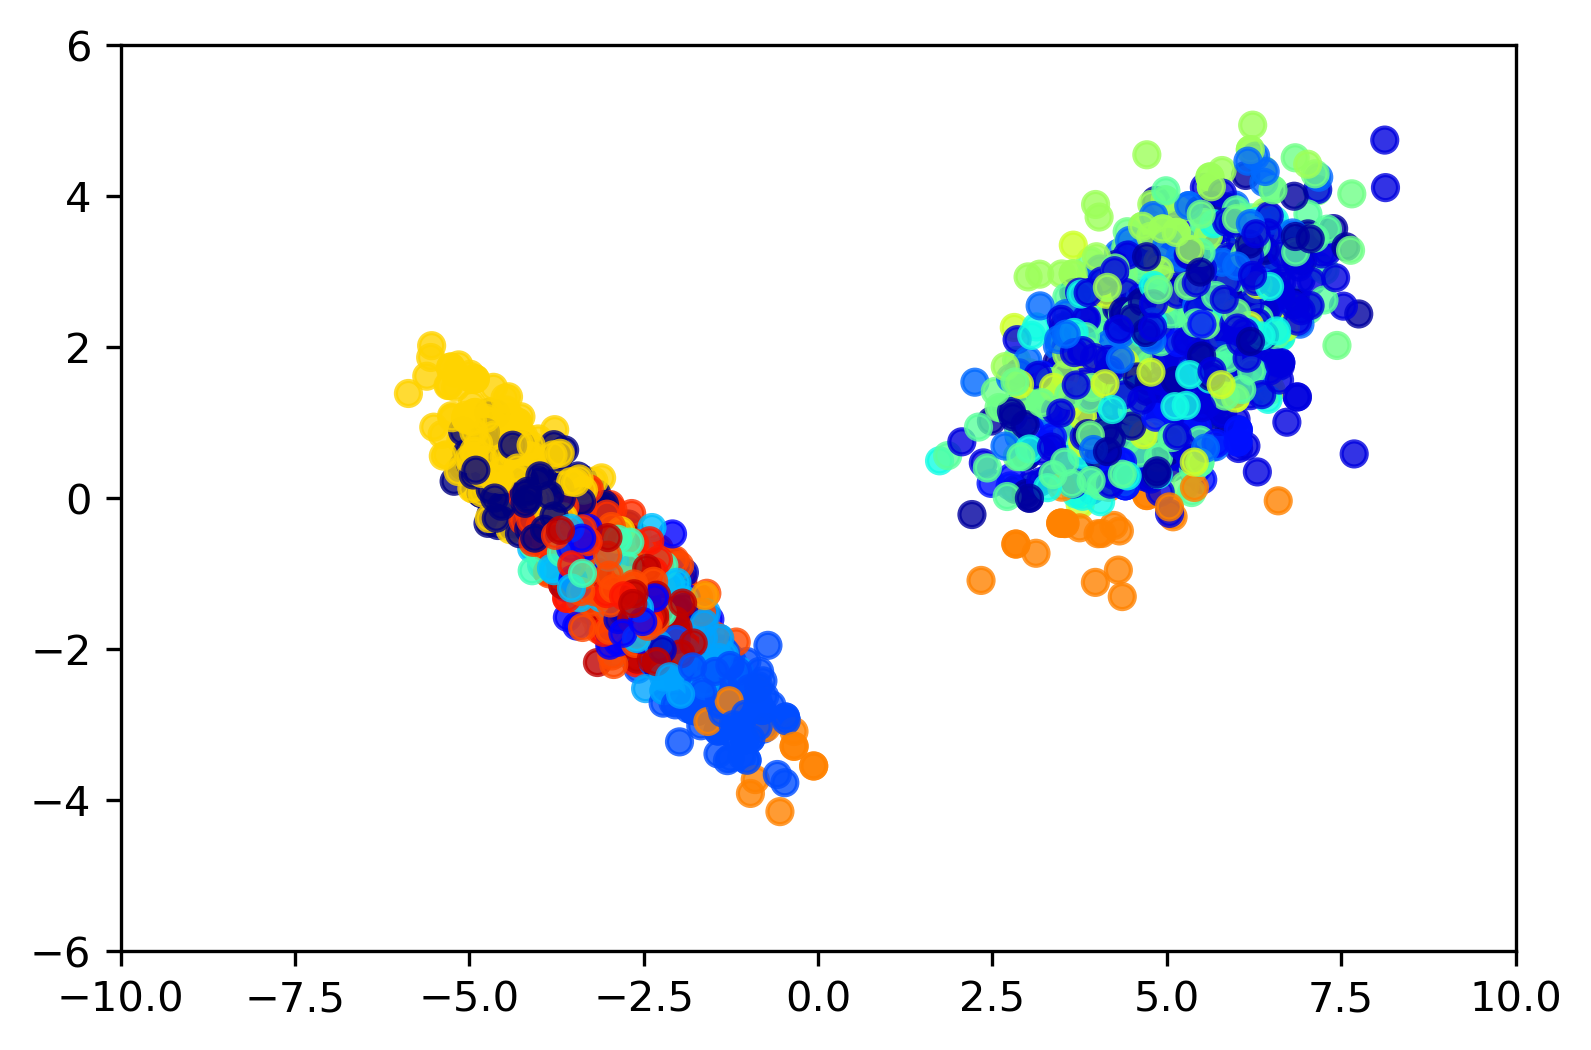

In [17]:
col = post_sample_choice
_, col1 = np.unique(col, return_inverse=True)


plot_n = 3000
plt.figure(figsize=[6, 4])
plt.scatter(theta_sample[:plot_n,0],theta_sample[:plot_n,1],c=col1[:plot_n], alpha=.8,cmap='jet_r')
plt.ylim(-6,6)
plt.xlim(-10,10)